# Livrable 2 - Traitement d'images


## SUJET

**Description du livrable**
Le notebook devra intégrer :

- Le code de chargement du fichier.

- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.

- Une étude de cas.

Pour réaliser cette phase, vous pourrez exploiter le dataset disponible. Attention, ce dataset contient des images en RGB, ce qui correspond au workflow que vous devrez implémenter tout au long de ce projet.

## Introduction

**Présentation du Projet**

Dans ce projet, nous nous concentrons sur l'optimisation des images pour les rendre plus compatibles avec les algorithmes d'apprentissage automatique, en mettant un accent particulier sur le processus de débruitage. Le débruitage est une étape cruciale dans le traitement d'images, en particulier lorsqu'il s'agit de préparer des données pour des modèles de Machine Learning. Notre objectif est de développer et d'implémenter une méthode efficace pour améliorer la qualité des images en utilisant des auto-encodeurs à convolution. Ces auto-encodeurs sont des réseaux de neurones conçus spécifiquement pour traiter des données sous forme d'images.

Le projet s'articulera autour de la création d'un notebook Jupyter, qui servira de guide complet pour le processus de débruitage. Ce notebook inclura le code nécessaire pour le chargement des images, leur traitement par débruitage, et une étude de cas pour démontrer l'efficacité de notre approche. Les images que nous traiterons sont en format RGB, ce qui est représentatif de nombreuses applications réelles dans le domaine du traitement d'images.

**Importance du Débruitage dans le Traitement d'Images pour le Machine Learning**

Le débruitage joue un rôle fondamental dans le domaine du traitement d'images, particulièrement en ce qui concerne les applications de Machine Learning. Les images, dans leur forme originale, peuvent souvent contenir divers types de bruits tels que le bruit de fond, le grain, ou les artefacts dus à la compression. Ce bruit peut significativement altérer la qualité des données, conduisant à une dégradation des performances des modèles de Machine Learning.

En Machine Learning, la qualité des données d'entrée est primordiale. Des données bruitées peuvent entraîner des erreurs d'apprentissage, une mauvaise généralisation et, en fin de compte, des prédictions inexactes. Le débruitage aide à améliorer la clarté et la qualité des données d'images, ce qui permet aux algorithmes d'apprentissage automatique de se concentrer sur les caractéristiques pertinentes et d'ignorer les distractions inutiles.

En utilisant des techniques avancées comme les auto-encodeurs à convolution, nous pouvons effectuer un débruitage efficace tout en préservant les caractéristiques importantes de l'image. Cette approche est particulièrement utile pour les applications où la précision et la clarté des images sont cruciales, comme dans le diagnostic médical par imagerie, la reconnaissance faciale, et la surveillance par vision par ordinateur.

Notre projet vise donc non seulement à améliorer la qualité visuelle des images mais aussi à augmenter leur utilité dans les contextes de Machine Learning, en fournissant un traitement préalable qui facilite et optimise l'apprentissage automatique.



## Configuration de l'Environnement

Avant de commencer le traitement et l'analyse des images, il est essentiel de configurer correctement l'environnement de travail. Cette configuration implique l'installation et l'importation des bibliothèques nécessaires pour mener à bien le projet. Ces bibliothèques fournissent les outils et fonctions nécessaires pour manipuler les images, construire et entraîner des modèles d'apprentissage automatique, et visualiser les résultats.

### Installation des Bibliothèques

In [ ]:
# !pip install pandas matplotlib Pillow scikit-learn seaborn keras-tuner prettytable scikit-image
# !pip install tensorflow[and-cuda]

### Importation des Bibliothèques

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from prettytable import PrettyTable

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
import math

from tensorflow.keras.regularizers import l1_l2, l2,l1
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.callbacks import TensorBoard
import datetime

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, UpSampling2D, Input, add, BatchNormalization, Activation,LeakyReLU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from kerastuner.tuners import Hyperband

from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Conv2DTranspose, Add, GlobalAveragePooling2D ,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Multiply

import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from kerastuner.tuners import BayesianOptimization


Vérification des GPUs

In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


## Configuration des Paramètres Généraux

In [ ]:
# Exemple de configuration de paramètres
lite_run = False
IMG_SIZE = 256 # @param {type:"number"}
CHANNELS = 3 # @param {type:"integer"}
BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 100 # @param {type:"integer"}
LEARNING_RATE = 0.0006 # @param {type:"number"}
SEED = 42 # @param {type:"integer"}
NB_EPOCHS_DENOISE = 50 # @param {type:"integer"}
WORKERS = 10 # @param {type:"number"}
if lite_run:
    train_data_size = 1965      # Remplacez par le nombre total d'images dans l'ensemble d'entraînement
    validation_data_size = 491 # Remplacez par le nombre total d'images dans l'ensemble de validation
else :
    train_data_size = 8036      # Remplacez par le nombre total d'images dans l'ensemble d'entraînement
    validation_data_size = 2009
test_data_size = 265 # Remplacez par le nombre total d'images dans l'ensemble de test

grid_result = {}
model_results = {}

## Configuration de l'import de données

### Configuration et Chargement des Données
**Définition des Sources de Données**
Selon l'environnement d'exécution, le code ajuste la source des données :

- **Environnement Local** : Le chemin vers le dossier contenant les données est spécifié manuellement.
- **Google Colab** : Les données sont chargées depuis Google Drive.





In [ ]:
local = True # @param {type:"boolean"}
 # @param {type:"boolean"}

# Chemin vers le dossier contenant les données

if local :
  data_dir = "/mnt/f/Projet_Data/Option-DaTA"
  models_save_dir = '/mnt/f/Projet_Data/Option-DaTA/models_livrable2'
  if lite_run:
    data_dir = "/mnt/f/Projet_Data/lite_run"
    models_save_dir = '/mnt/f/Projet_Data/lite_run/models_livrable2'
else :
  from google.colab import drive
  drive.mount('/content/drive')
  data_dir = '/content/data/'
  if os.path.exists(data_dir) :
    os.system(f"rm -rf {data_dir}")
    os.makedirs(os.path.join(data_dir, 'Dataset2'))
    !cp -r "/content/drive/MyDrive/Colab Notebooks/Dataset-Option-Data/Dataset2" "/content/data/"

  else :
    os.makedirs(os.path.join(data_dir, 'Dataset2'))
    !cp -r "/content/drive/MyDrive/Colab Notebooks/Dataset-Option-Data/Dataset2" "/content/data/"



## Nettoyage et Décompression des Données (si nécessaire)
Pour garantir que les données sont à jour, le code offre la possibilité de supprimer et de décompresser à nouveau les datasets.

In [ ]:
rm_modifer_img = False # @param {type:"boolean"}
# Suppression des images modifiées
if rm_modifer_img:
  os.system(f"rm -rf {os.path.join(data_dir, 'Dataset2_modifier')}")

# Décompression des datasets


### Application du Prétraitement

Le prétraitement est appliqué à chaque catégorie d'images dans le dataset.

In [ ]:


def create_image_generators(data_dir, validation_split=0.2):
    """
    Crée des générateurs d'images pour les ensembles d'entraînement et de validation.
    """
    datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.15, validation_split=validation_split)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),

        color_mode='rgb',
        class_mode='input',
        subset='training',
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),

        color_mode='rgb',
        class_mode='input',
        subset='validation'
    )


    return train_generator, validation_generator

# Création des générateurs d'images
print(os.path.join(data_dir,"Dataset2"))
train_generator, validation_generator = create_image_generators(os.path.join(data_dir,"Dataset2"))


/mnt/f/Projet_Data/Option-DaTA/Dataset2
Found 8036 images belonging to 1 classes.
Found 2009 images belonging to 1 classes.


In [ ]:
def create_image_test_generators(data_dir):
    """
    Crée des générateurs d'images pour les ensembles d'entraînement et de validation.
    """
    datagen = ImageDataGenerator(rescale=1./255)

    test_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False,
        color_mode='rgb',
        class_mode='input',

    )



    return test_generator

# Création des générateurs d'images
print(os.path.join(data_dir,"Dataset2_test"))

test_generator = create_image_test_generators(os.path.join(data_dir,"Dataset2_test"))

/mnt/f/Projet_Data/Option-DaTA/Dataset2_test
Found 265 images belonging to 1 classes.


In [ ]:


def add_noise(images, min_noise_factor=0.05, max_noise_factor=0.3):
    """
    Ajoute un bruit gaussien aux images, avec un facteur de bruit choisi
    aléatoirement dans la plage [min_noise_factor, max_noise_factor].
    """
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor)
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)



In [ ]:
def process_images_from_generator(generator, noise_factor=0.2):
    """
    Extrait des images d'un générateur, leur applique du bruit et renvoie les images bruitées.
    """
    while True:
        batch_images, _ = next(generator)  # Obtenir un batch d'images
        noisy_batch_images = add_noise(batch_images, noise_factor)  # Ajouter du bruit
        yield noisy_batch_images ,batch_images # Renvoie les images bruitées et les images originales


In [ ]:
noisy_train_generator = process_images_from_generator(train_generator)
noisy_validation_generator = process_images_from_generator(validation_generator)
noisy_test_generator = process_images_from_generator(test_generator)


In [ ]:
try:
    batch_images, _ = next(noisy_train_generator)
    print("Batch shape:", batch_images.shape)
except StopIteration:
    print("Le générateur est épuisé ou ne fournit pas de données.")



Batch shape: (32, 256, 256, 3)


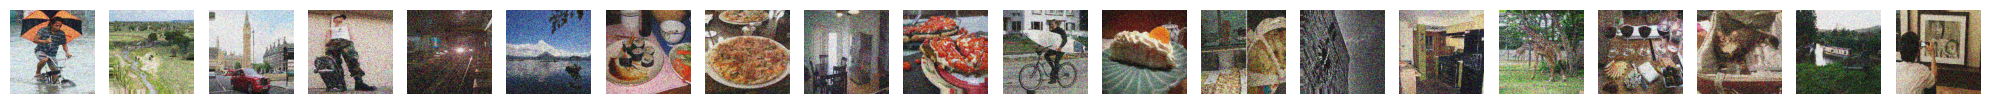

In [ ]:
import matplotlib.pyplot as plt

def display_images_from_generator(generator, num_images=5, figsize=(20, 20)):
    """
    Affiche un nombre spécifié d'images extraites d'un générateur de données.
    Args:
    - generator: le générateur de données d'images.
    - num_images: le nombre d'images à afficher.
    - figsize: la taille de la figure pour matplotlib.
    """
    plt.figure(figsize=figsize)

    for i in range(num_images):
        try:
            # Obtenir un batch d'images
            images, _ = next(generator)
            # Afficher la première image du batch
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[0])
            plt.axis('off')
        except StopIteration:
            # Le générateur n'a plus de données
            print(f"Le générateur est épuisé après {i} images.")
            break

    plt.tight_layout()
    plt.show()

display_images_from_generator(noisy_train_generator, num_images=20)

## Conception de l'Auto-Encodeur à Convolution
Un auto-encodeur à convolution est un type de réseau de neurones utilisé pour l'apprentissage non supervisé. Il est particulièrement efficace dans le traitement d'images, notamment pour des tâches telles que le débruitage. Cette section se concentre sur la conception de l'architecture de l'auto-encodeur.



## Plan d'expérience

In [ ]:

def evaluate_model(model, generator, steps):
    """
    Évalue le modèle en utilisant MAE, SSIM, et PSNR.
    :param model: Le modèle d'auto-encodeur.
    :param generator: ImageDataGenerator fournissant les données de test.
    :param steps: Nombre de pas par époque.
    :return: Un dictionnaire contenant les métriques d'évaluation.
    """
    mae_scores = []
    ssim_scores = []
    psnr_scores = []

    for _ in range(steps):
        data, labels = next(generator)
        predictions = model.predict(data)

        for pred, true in zip(predictions, labels):
            mae_scores.append(tf.keras.losses.mean_absolute_error(true, pred).numpy())
            ssim_scores.append(ssim(true, pred, multichannel=True, channel_axis=-1, win_size=3, data_range=1))
            psnr_scores.append(psnr(true, pred, data_range=1))  # Assurez-vous que data_range correspond à la plage de vos données d'image

    evaluation_results = {
        'MAE': np.mean(mae_scores),
        'SSIM': np.mean(ssim_scores),
        'PSNR': np.mean(psnr_scores)
    }

    return evaluation_results


In [ ]:
# Fonction pour afficher les comparaisons
def display_comparisons(noisy, predicted, original, sharpened,num_images_to_show):
    plt.figure(figsize=(20, 8))  # Augmentez la hauteur pour une rangée supplémentaire
    for i in range(num_images_to_show):
        # Image bruitée
        ax = plt.subplot(4, num_images_to_show, i + 1)
        plt.imshow(noisy[i].reshape(256, 256, 3))
        ax.set_title("Bruitée")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Image débruitée mais floue
        ax = plt.subplot(4, num_images_to_show, num_images_to_show + i + 1)
        plt.imshow(predicted[i].reshape(256, 256, 3))
        ax.set_title("Débruitée Floue")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Image originale
        ax = plt.subplot(4, num_images_to_show, 2 * num_images_to_show + i + 1)
        plt.imshow(original[i].reshape(256, 256, 3))
        ax.set_title("Originale")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Image défloutée
        ax = plt.subplot(4, num_images_to_show, 3 * num_images_to_show + i + 1)
        plt.imshow(sharpened[i].reshape(256, 256, 3))
        ax.set_title("Défloutée")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()




In [ ]:
def testing_visualisation(history,autoencoder,step):
  # Plotting the training and validation losses
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.yscale('log')
  plt.legend(loc='upper right')
  plt.show()

  # lr_values = history.history['lr']
  # epochs = range(len(lr_values))

  # plt.plot(epochs, lr_values, label='training')
  # plt.title('Learning Rate vs. Epochs')
  # plt.ylabel('Learning Rate')
  # plt.xlabel('Epoch')
  # plt.yscale('log')
  # # Sélectionner un sous-ensemble représentatif pour les graduations
  # valeurs_selectionnees = np.array([lr_values[i] for i in range(0, len(lr_values), 20)])
  # plt.yticks(valeurs_selectionnees, labels=[f'{val:.1e}' for val in valeurs_selectionnees])

  # plt.legend(loc='upper right')
  # plt.show()

  # Générez des images débruitées à partir de votre autoencoder
  denoised_images = autoencoder.predict(noisy_test_generator, steps=test_data_size//BATCH_SIZE)

  # Extraction d'un batch d'images du validation_generator et du noisy_validation_generator
  noisy_images_batch, _ = next(noisy_test_generator)

  # Nombre d'images à afficher
  N = min(len(noisy_images_batch), 4)

  # Assurez-vous que denoised_images, noisy_images_batch et clean_images_batch sont disponibles et correctement formatés
  plt.figure(figsize=(13, 6))

  for i in range(N):
      # Afficher les images bruitées (avant entraînement)
      ax = plt.subplot(3, N, i + 1)
      plt.imshow(noisy_images_batch[i])
      plt.title("Noisy Pre-Training")
      plt.axis('off')

      # Afficher les images débruitées (après entraînement)
      ax = plt.subplot(3, N, i + 1 + N)
      denoised_img = denoised_images[i] * 255
      plt.imshow(denoised_img.astype("uint8"))
      plt.title("Denoised Post-Training")
      plt.axis('off')

  plt.tight_layout()
  plt.show()
  results = evaluate_model(autoencoder, test_generator,step)
  print("Résultats de l'évaluation du model: ", results)
  return results

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.01), patience=5, verbose=1)
# Chemin du répertoire où les logs seront stockés
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Créer une instance de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# autoencoder

In [ ]:
def create_autoencoder(hp):
    input_img = Input(shape=(256, 256, 3))
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    initial_filters = hp.Int('initial_filters', min_value=16, max_value=80, step=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    l1_reg = hp.Float('l1_reg', min_value=1e-6, max_value=1e-3, sampling='LOG')
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-3, sampling='LOG')
    x = input_img

    skip_connections = []
    # Encoder
    for i in range(num_layers):
        num_filters = initial_filters * (2 ** i)
        x = Conv2D(num_filters, (3, 3), padding='same',
                   kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                   activity_regularizer=l2(l2_reg) if l2_reg > 0 else None,
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, (3, 3), padding='same',
                   kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                   activity_regularizer=l2(l2_reg) if l2_reg > 0 else None,
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        skip_connections.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    # Decoder
    for i in range(num_layers - 1, -1, -1):
        num_filters = initial_filters * (2 ** i)
        x = UpSampling2D((2, 2))(x)

        # Concatenation with skip connection
        skip_layer = skip_connections.pop()
        x = Concatenate()([x, skip_layer])

        x = Conv2D(num_filters, (3, 3), padding='same',
                   kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                   activity_regularizer=l2(l2_reg) if l2_reg > 0 else None,
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, (3, 3), padding='same',
                   kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                   activity_regularizer=l2(l2_reg) if l2_reg > 0 else None,
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return autoencoder


## Config

In [ ]:
tuner = BayesianOptimization(
    create_autoencoder,
    objective='val_loss',
    max_trials=15,
    num_initial_points=3,
    directory='keras_tuner_dir_bayesian',
    project_name='autoencoder_bayesian_3'
)

tuner.search_space_summary()

EPOCHS = 50
tuner.search(
    train_generator,  # Générateur de données d'entraînement
    epochs=EPOCHS,  # Nombre d'époques pour l'entraînement
    batch_size=BATCH_SIZE,  # Taille du lot
    validation_data=validation_generator,  # Générateur de données de validation
    callbacks=[early_stopping,reduce_lr],# Callback pour arrêter l'entraînement de manière anticipé
    verbose = 2
)
EPOCHS = 100


Reloading Tuner from keras_tuner_dir_bayesian/autoencoder_bayesian_3/tuner0.json
Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
initial_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 80, 'step': 16, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
l1_reg (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
l2_reg (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

best_model = tuner.hypermodel.build(best_hyperparameters)
print(best_hyperparameters.values)

{'num_layers': 3, 'initial_filters': 16, 'learning_rate': 0.001301268108890271, 'dropout_rate': 0.1, 'l1_reg': 2.1537510546437325e-05, 'l2_reg': 1.255667561137607e-06}


In [ ]:
# Définir le chemin de sauvegarde et sauvegarder le modèle
model_save_path = f"{models_save_dir}/best_model.h5"  # Chemin de sauvegarde
best_model.save(model_save_path)  # Sauvegarde le modèle au chemin spécifié
print(f"Saved model to {model_save_path}")  # Affiche le chemin où le modèle a été sauvegardé

# Affiche un résumé du modèle
best_model.summary()  # Résumé du modèle pour visualiser la structure et les paramètres



Saved model to /mnt/f/Projet_Data/Option-DaTA/models_livrable2/best_model.h5
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 256, 256, 16)         448       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (None, 256, 256, 16)         64        ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 

/home/mat/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
results = evaluate_model(best_model, test_generator,test_data_size//BATCH_SIZE)
print("Résultats de l'évaluation du model: ", results)

model_results["Best_Autoencoder"] = results

1/1 [==============================] - 0s 24ms/step
Résultats de l'évaluation du model:  {'MAE': 0.23153986, 'SSIM': 0.37487268, 'PSNR': 11.626194265748156}


In [ ]:
BATCH_SIZE = 64
# Obtenir le meilleur essai
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# Construction du modèle avec les meilleurs hyperparamètres
model = tuner.hypermodel.build(best_trial.hyperparameters)
model.summary()

# Entraînement du modèle avec les données d'entraînement et de validation
history = model.fit(
    train_generator,
    steps_per_epoch= train_data_size // BATCH_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_steps = validation_data_size // BATCH_SIZE,
    validation_data=validation_generator,

    callbacks=[early_stopping,reduce_lr],
    verbose = 2
)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 256, 256, 16)         448       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_84 (Ba  (None, 256, 256, 16)         64        ['conv2d_91[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_84 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_84

2024-01-12 00:04:57.525452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 - 79s - loss: 2.7714 - val_loss: 0.3355 - lr: 0.0013 - 79s/epoch - 632ms/step
Epoch 2/100
125/125 - 68s - loss: 0.6382 - val_loss: 0.2320 - lr: 0.0013 - 68s/epoch - 541ms/step
Epoch 3/100
125/125 - 65s - loss: 0.3205 - val_loss: 0.1821 - lr: 0.0013 - 65s/epoch - 518ms/step
Epoch 4/100
125/125 - 63s - loss: 0.2024 - val_loss: 0.1382 - lr: 0.0013 - 63s/epoch - 507ms/step
Epoch 5/100
125/125 - 62s - loss: 0.1851 - val_loss: 0.1188 - lr: 0.0013 - 62s/epoch - 500ms/step
Epoch 6/100
125/125 - 64s - loss: 0.1082 - val_loss: 0.0855 - lr: 0.0013 - 64s/epoch - 512ms/step
Epoch 7/100
125/125 - 64s - loss: 0.1341 - val_loss: 0.1160 - lr: 0.0013 - 64s/epoch - 514ms/step
Epoch 8/100
125/125 - 64s - loss: 0.1337 - val_loss: 0.0964 - lr: 0.0013 - 64s/epoch - 509ms/step
Epoch 9/100
125/125 - 63s - loss: 0.0820 - val_loss: 0.0647 - lr: 0.0013 - 63s/epoch - 504ms/step
Epoch 10/100
125/125 - 64s - loss: 0.0509 - val_loss: 0.0496 - lr: 0.0013 - 64s/epoch - 509ms/step
Epoch 11/100
125/125 - 64s - lo

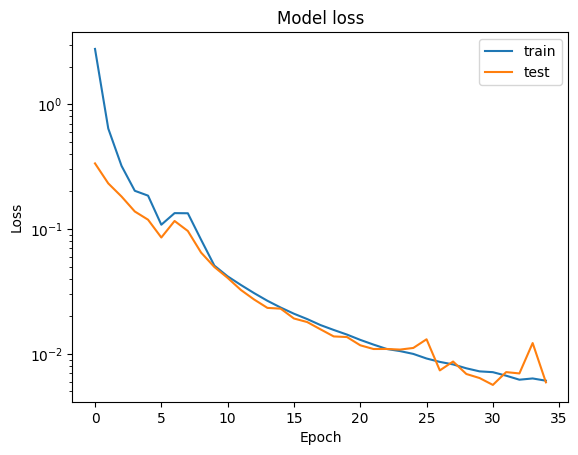

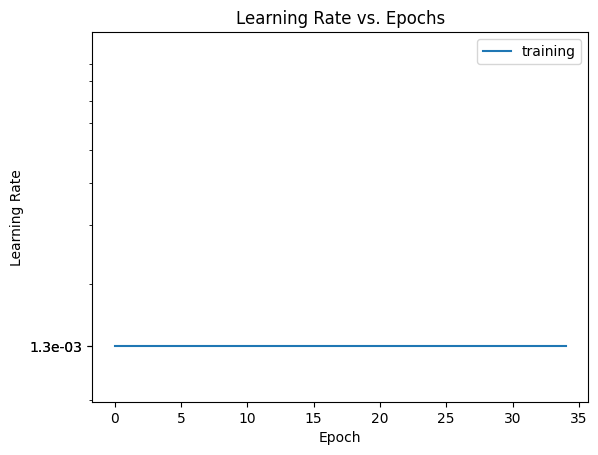

4/4 [==============================] - 1s 305ms/step


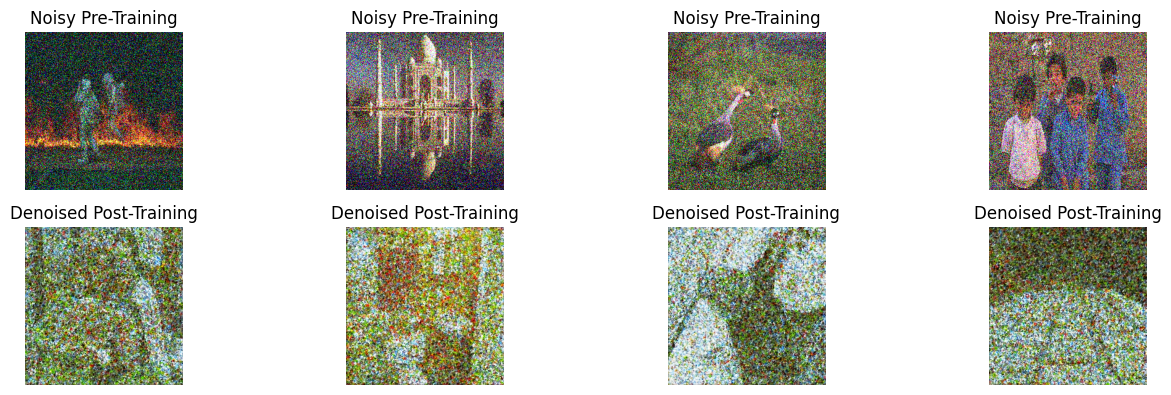

1/1 [==============================] - 0s 198ms/step
Résultats de l'évaluation du model:  {'MAE': 0.035150442, 'SSIM': 0.86343586, 'PSNR': 26.988450032559207}
Saved model to /mnt/f/Projet_Data/Option-DaTA/models_livrable2/best_model_retrain.h5


/home/mat/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Optionnelle : Visualisation des données d'entraînement
results = testing_visualisation(history, model,test_data_size//BATCH_SIZE)
model_results["Best_Autoencoder_retrain"] = results
model_save_path = f"{models_save_dir}/best_model_retrain.h5"  # Chemin de sauvegarde
model.save(model_save_path)  # Sauvegarde le modèle au chemin spécifié
print(f"Saved model to {model_save_path}") # Affiche le chemin où le modèle a été sauvegard


# CBDNet — Convolutional Blind Denoising Network [6]

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

#Noise estimation subnetwork
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)

#Non Blind denoising subnetwork
x = concatenate([x,input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = Add()([upsample2,conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = Conv2D(3, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = Add()([out,input])

CBDNet = Model(input,out)
CBDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
CBDNet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
plot_model(model, to_file='model_diagram.png', show_shapes=True)


In [ ]:
history = CBDNet.fit(noisy_train_generator,
                    shuffle=True,
                    steps_per_epoch= train_data_size // BATCH_SIZE,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,

                    validation_data=noisy_validation_generator,
                    validation_steps = validation_data_size // BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose = 2)


Epoch 1/100
125/125 - 105s - loss: 0.0324 - val_loss: 0.0076 - lr: 0.0010 - 105s/epoch - 841ms/step
Epoch 2/100
125/125 - 87s - loss: 0.0069 - val_loss: 0.0063 - lr: 0.0010 - 87s/epoch - 694ms/step
Epoch 3/100
125/125 - 83s - loss: 0.0058 - val_loss: 0.0054 - lr: 0.0010 - 83s/epoch - 660ms/step
Epoch 4/100
125/125 - 80s - loss: 0.0054 - val_loss: 0.0048 - lr: 0.0010 - 80s/epoch - 642ms/step
Epoch 5/100
125/125 - 73s - loss: 0.0049 - val_loss: 0.0043 - lr: 0.0010 - 73s/epoch - 584ms/step
Epoch 6/100
125/125 - 72s - loss: 0.0045 - val_loss: 0.0041 - lr: 0.0010 - 72s/epoch - 574ms/step
Epoch 7/100
125/125 - 73s - loss: 0.0043 - val_loss: 0.0040 - lr: 0.0010 - 73s/epoch - 582ms/step
Epoch 8/100
125/125 - 72s - loss: 0.0041 - val_loss: 0.0040 - lr: 0.0010 - 72s/epoch - 573ms/step
Epoch 9/100
125/125 - 72s - loss: 0.0040 - val_loss: 0.0036 - lr: 0.0010 - 72s/epoch - 576ms/step
Epoch 10/100
125/125 - 71s - loss: 0.0038 - val_loss: 0.0038 - lr: 0.0010 - 71s/epoch - 567ms/step
Epoch 11/100
125/

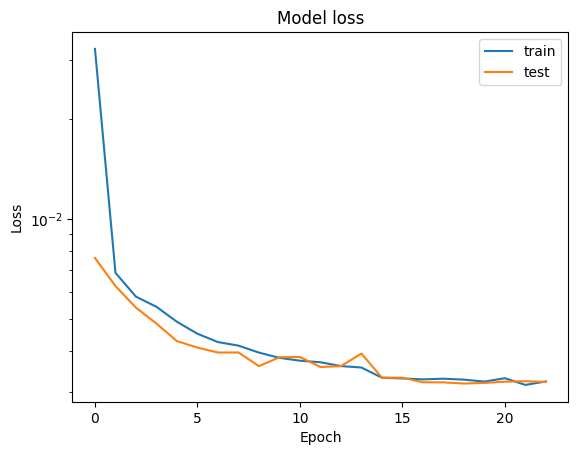

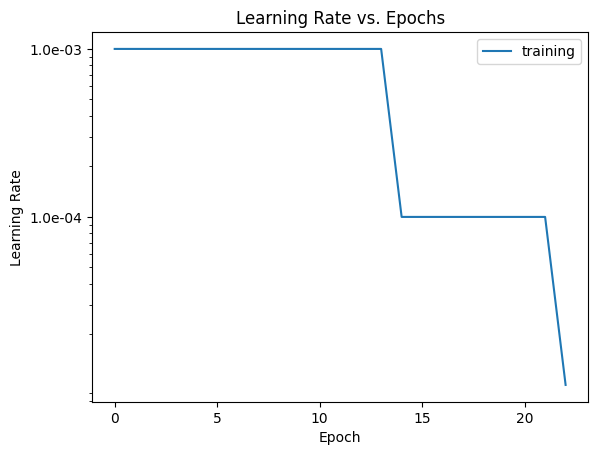

4/4 [==============================] - 1s 299ms/step


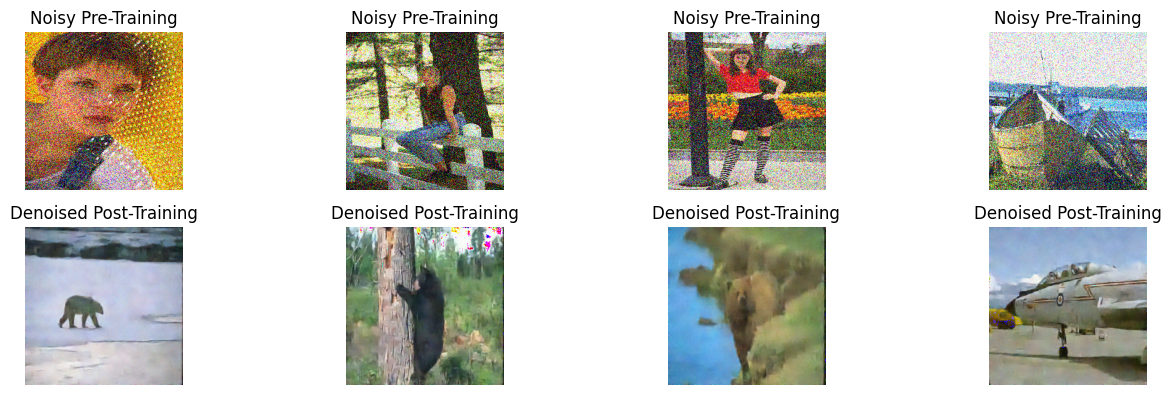

1/1 [==============================] - 0s 21ms/step
Résultats de l'évaluation du model:  {'MAE': 0.04839437, 'SSIM': 0.6261439, 'PSNR': 24.031112437013796}


In [ ]:
results = testing_visualisation(history, CBDNet,test_data_size//BATCH_SIZE )
model_results["CBDNet"] = results


In [ ]:
#model_results["CBDNet"] = results
model_save_path = f"{models_save_dir}/CBDNet.h5"  # Chemin de sauvegarde
CBDNet.save(model_save_path)  # Sauvegarde le modèle au chemin spécifié
print(f"Saved model to {model_save_path}") # Affiche le chemin où le modèle a été sauvegard

Saved model to /mnt/f/Projet_Data/Option-DaTA/models_livrable2/CBDNet.h5


/home/mat/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# PRIDNet — Pyramid Real Image Denoising Network

In [ ]:
#https://github.com/491506870/PRIDNet/blob/master/network.py
class convolutional_block1(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv4 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
      config = super().get_config().copy()
      config.update({'filters': self.filters})
      return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        return X


In [ ]:
class CAM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.gap = GlobalAveragePooling2D()
    self.dense1 = Dense(units=2,activation='relu')
    self.dense2 = Dense(units=32,activation='sigmoid')

  def call(self, X):
    Y = self.gap(X)
    Y = self.dense1(Y)
    Y = self.dense2(Y)
    X = Multiply()([X,Y])
    return X


## Multi Stage Denoising

In [ ]:
class convolutional_block2(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
        config = super().get_config().copy()
        config.update({'filters': self.filters})
        return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        return X

In [ ]:
class pyramid(tf.keras.layers.Layer):
  def __init__(self,pool_size, upsample_size, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size
    self.upsample_size = upsample_size
    self.upsample = UpSampling2D(self.upsample_size, interpolation='bilinear')
    self.pool = AveragePooling2D(pool_size=(self.pool_size,self.pool_size))

    self.conv1 = convolutional_block1(filters=32)
    self.maxpool1 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv2 = convolutional_block1(filters=64)
    self.maxpool2 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv3 = convolutional_block1(filters=128)
    self.maxpool3 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv4 = convolutional_block1(filters=256)
    self.maxpool4 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv5 = convolutional_block1(filters=512)

    self.upsample1 = Conv2DTranspose(256, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv6 = convolutional_block2(filters=256)

    self.upsample2 = Conv2DTranspose(128, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv7 = convolutional_block2(filters=128)

    self.upsample3 = Conv2DTranspose(64, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv8 = convolutional_block2(filters=64)

    self.upsample4 = Conv2DTranspose(32, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv9 = convolutional_block2(filters=32)

    self.conv10 = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')

  def get_config(self):
    config = super().get_config().copy()
    config.update({'pool_size': self.pool_size,'upsample_size':self.upsample_size})
    return config

  def call(self, input):
    conv1 = self.pool(input)

    conv1 = self.conv1(conv1)
    pool1 = self.maxpool1(conv1)

    conv2 = self.conv2(pool1)
    pool2 = self.maxpool2(conv2)

    conv3 = self.conv3(pool2)
    pool3 = self.maxpool3(conv3)

    conv4 = self.conv4(pool3)
    pool4 = self.maxpool4(conv4)

    conv5 = self.conv5(pool4)

    up1 = self.upsample1(conv5)
    concat1 = concatenate([up1,conv4])
    conv6 = self.conv6(concat1)

    up2 = self.upsample2(conv6)
    concat2 = concatenate([up2,conv3])
    conv7 = self.conv7(concat2)


    up3 = self.upsample3(conv7)
    concat3 = concatenate([up3,conv2])
    conv8 = self.conv8(concat3)

    up4 = self.upsample4(conv8)
    concat4 = concatenate([up4,conv1])
    conv9 = self.conv9(concat4)

    conv10 = self.conv10(conv9)
    out = self.upsample(conv10)

    return out

## Feature Fusion Stage

In [ ]:
class KSM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.conv1 = Conv2D(filters = 21, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv2 = Conv2D(filters = 21, kernel_size=5,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv3 = Conv2D(filters = 21, kernel_size=7,activation='relu',padding='same',kernel_initializer='he_normal')
    self.gap = GlobalAveragePooling2D()
    self.fc1 = Dense(units=2,activation='relu')
    self.fc2_1 = Dense(units=21)
    self.fc2_2 = Dense(units=21)
    self.fc2_3 = Dense(units=21)

  def call(self, input):
    conv1 = self.conv1(input)
    conv2 = self.conv2(input)
    conv3 = self.conv3(input)
    sum = Add()([conv1,conv2,conv3])
    gap =  self.gap(sum)
    gap = tf.reshape(gap, [-1, 1, 1, 21])
    fc1 = self.fc1(gap)
    a1 = self.fc2_1(fc1)
    a2 = self.fc2_2(fc1)
    a3 = self.fc2_3(fc1)

    before_softmax = concatenate([a1, a2, a3],1)
    after_softmax = softmax(before_softmax,axis=1)

    a1 = after_softmax[:, 0, :, :]
    a1 = tf.reshape(a1, [-1, 1, 1, 21])

    a2 = after_softmax[:, 1, :, :]
    a2 = tf.reshape(a2, [-1, 1, 1, 21])

    a3 = after_softmax[:, 2, :, :]
    a3 = tf.reshape(a3, [-1, 1, 1, 21])

    out1 = Multiply()([a1,conv1])
    out2 = Multiply()([a2,conv2])
    out3 = Multiply()([a3,conv3])
    out = Add()([out1,out2,out3])
    return out

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

C1 = convolutional_block1(filters=32)(input)
cam = CAM()(C1)
C2 = Conv2D(filters = 3, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')(cam)
concat1 = concatenate([C2,input])

p1 = pyramid(pool_size=1,upsample_size=1)(concat1)
p2 = pyramid(pool_size=2,upsample_size=2)(concat1)
p3 = pyramid(pool_size=4,upsample_size=4)(concat1)
p4 = pyramid(pool_size=8,upsample_size=8)(concat1)
p5 = pyramid(pool_size=16,upsample_size=16)(concat1)

concat2 = concatenate([p1,p2,p3,p4,p5,concat1])
ksm = KSM()(concat2)
out = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')(ksm)

PRIDNet = Model(input,out)
PRIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
PRIDNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 convolutional_block1 (conv  (None, 256, 256, 32)         28640     ['input_1[0][0]']             
 olutional_block1)                                                                                
                                                                                                  
 cam (CAM)                   (None, 256, 256, 32)         162       ['convolutional_block1[0][0]']
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 3)          867       ['cam[0][0]']             

In [ ]:
history = PRIDNet.fit(noisy_train_generator,
                    shuffle=True,
                    steps_per_epoch= train_data_size // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=noisy_validation_generator,
                    validation_steps = validation_data_size // BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose = 2)


Epoch 1/100
125/125 - 106s - loss: 0.0065 - val_loss: 0.0054 - 106s/epoch - 851ms/step
Epoch 2/100
125/125 - 86s - loss: 0.0051 - val_loss: 0.0046 - 86s/epoch - 691ms/step
Epoch 3/100
125/125 - 85s - loss: 0.0045 - val_loss: 0.0043 - 85s/epoch - 677ms/step
Epoch 4/100
125/125 - 82s - loss: 0.0042 - val_loss: 0.0039 - 82s/epoch - 655ms/step
Epoch 5/100
125/125 - 81s - loss: 0.0041 - val_loss: 0.0040 - 81s/epoch - 646ms/step
Epoch 6/100
125/125 - 82s - loss: 0.0037 - val_loss: 0.0036 - 82s/epoch - 655ms/step
Epoch 7/100
125/125 - 82s - loss: 0.0037 - val_loss: 0.0036 - 82s/epoch - 653ms/step
Epoch 8/100
125/125 - 82s - loss: 0.0037 - val_loss: 0.0036 - 82s/epoch - 655ms/step
Epoch 9/100
125/125 - 81s - loss: 0.0035 - val_loss: 0.0035 - 81s/epoch - 645ms/step
Epoch 10/100
125/125 - 80s - loss: 0.0036 - val_loss: 0.0034 - 80s/epoch - 639ms/step
Epoch 11/100
125/125 - 81s - loss: 0.0034 - val_loss: 0.0034 - 81s/epoch - 647ms/step
Epoch 12/100
125/125 - 81s - loss: 0.0034 - val_loss: 0.0033 

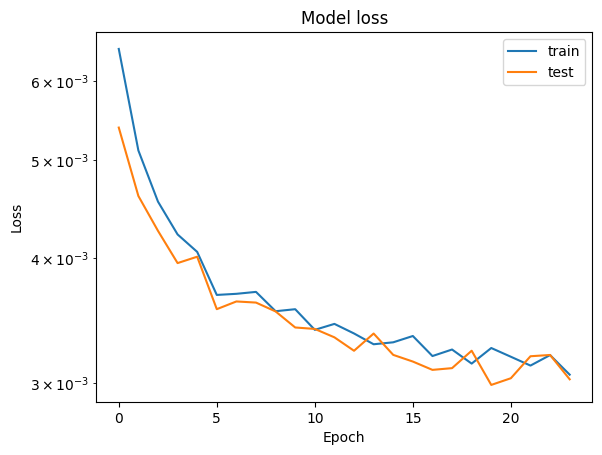

4/4 [==============================] - 4s 634ms/step


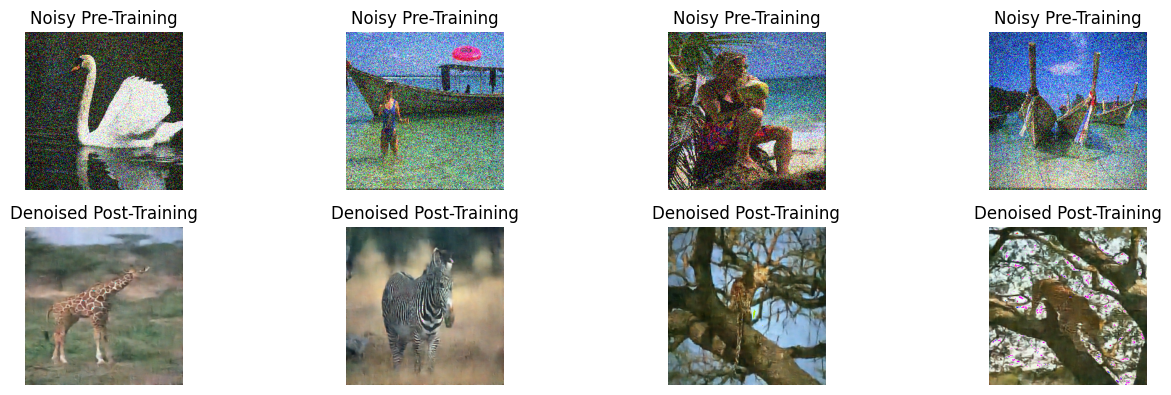

1/1 [==============================] - 0s 81ms/step
Résultats de l'évaluation du model:  {'MAE': 0.041696634, 'SSIM': 0.656538, 'PSNR': 25.241951618684784}
Saved model to /mnt/f/Projet_Data/Option-DaTA/models_livrable2/PRIDNet.h5


In [ ]:
results = testing_visualisation(history, PRIDNet,test_data_size//BATCH_SIZE)
model_results["PRIDNet"] = results
model_save_path = f"{models_save_dir}/PRIDNet.h5"  # Chemin de sauvegarde
PRIDNet.save(model_save_path)  # Sauvegarde le modèle au chemin spécifié
print(f"Saved model to {model_save_path}") # Affiche le chemin où le modèle a été sauvegard

# Resultats des models

In [ ]:
def store_results_in_prettytable(model_results):
    # Créer un objet PrettyTable
    table = PrettyTable()

    # Définir les colonnes de la table
    table.field_names = ["Model", "MAE", "SSIM", "PSNR"]

    # Ajouter les résultats de chaque modèle à la table
    for model_name, metrics in model_results.items():
        mae, ssim, psnr = metrics['MAE'], metrics['SSIM'], metrics['PSNR']
        table.add_row([model_name, f"{mae:.4f}", f"{ssim:.4f}", f"{psnr:.4f}"])

    # Afficher la table
    print(table)


In [ ]:
store_results_in_prettytable(model_results)

+--------------------------+--------+--------+---------+
|          Model           |  MAE   |  SSIM  |   PSNR  |
+--------------------------+--------+--------+---------+
|     Best_Autoencoder     | 0.2315 | 0.3749 | 11.6262 |
| Best_Autoencoder_retrain | 0.0352 | 0.8634 | 26.9885 |
|          CBDNet          | 0.0484 | 0.6261 | 24.0311 |
|         PRIDNet          | 0.0417 | 0.6565 | 25.2420 |
+--------------------------+--------+--------+---------+
